### 0 - Bibliotecas

In [1]:
## Processamento de dados
import numpy as np
import pandas as pd
import pandas_profiling
from pandas_profiling import ProfileReport
import random

#Bibliotecas utilizadas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

## Vusualização de dados
import matplotlib.pyplot as plt
from IPython.display import Image

### pip install --upgrade scikit-learn
%matplotlib inline

In [2]:
import warnings 
warnings.filterwarnings("ignore")

### 1 - Dado Original

In [3]:
# Leitura do dataset
df = pd.read_csv('forestfires.csv')
# Transformação da dimensão 'área' pelo seu logaritmo (depois de somar 1 para evitar zeros)
df['Logarea']=np.log10(df['area']+1)
# Codificação de rótulos para dimensões categóricas (dia e mês)
# Codificação MES
enc = LabelEncoder()
enc.fit(df['month'])
enc.classes_
df['month_encoded']=enc.transform(df['month'])
# Codificação DIA
enc.fit(df['day'])
enc.classes_
df['day_encoded']=enc.transform(df['day'])
df

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,Logarea,month_encoded,day_encoded
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00,0.000000,7,0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00,0.000000,10,5
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00,0.000000,10,2
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00,0.000000,7,0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00,0.000000,7,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44,0.871573,1,3
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29,1.742647,1,3
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16,1.084934,1,3
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00,0.000000,1,2


#### OBSERVAÇÃO - 517 ELEMENTOS - FAREMOS O SAMPLING DE 50 ELEMENTOS

### 3 - APLICAÇÃO DOS 4 MÉTODOS
    - a) support vector regression
    - b) decision tree
    - c) random forest
    - d) 3-layer dense neural network

In [5]:
### Método 1 - Support Vector Regressor (SVR) - Regressor vetorial de suporte (SVR)
# configuração do tamanho do conjunto-teste
test_size=0.4
df_sample = df
# segmentação teste-treino
X_data=df_sample.drop(['area','Logarea','month','day'],axis=1)
y_data=df_sample['Logarea']
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size)
y_train=y_train.values.reshape(y_train.size,1)
#y_train=y_train.reshape(y_train.size,1)
def rec(m,n,tol):
    if type(m)!='numpy.ndarray':
        m=np.array(m)
    if type(n)!='numpy.ndarray':
        n=np.array(n)
    l=m.size
    percent = 0
    for i in range(l):
        if np.abs(10**m[i]-10**n[i])<=tol:
            percent+=1
    return 100*(percent/l)
# Definir o limite máximo de tolerância para o eixo x da curva REC - Para este problema, isso 
# representa o valor absoluto do erro na previsão do resultado, ou seja, a área queimada
tol_max=20
### Support Vector Regressor (SVR)
scaler = StandardScaler()
# Parameter grid for the Grid Search
param_grid = {'C': [0.01,0.1,1, 10], 'epsilon': [10,1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']}
grid_SVR = GridSearchCV(SVR(),param_grid,refit=True,verbose=0,cv=5)
grid_SVR.fit(scaler.fit_transform(X_train),scaler.fit_transform(y_train))
print("Best parameters obtained by Grid Search:",grid_SVR.best_params_)
a=grid_SVR.predict(X_test)
RMSE_SVR = np.sqrt(np.mean((y_test-a)**2))
#print("RMSE for Support Vector Regression:",np.sqrt(np.mean((y_test-a)**2)))
print("RMSE for Support Vector Regression:",RMSE_SVR)
rec_SVR=[]
for i in range(tol_max):
    rec_SVR.append(rec(a,y_test,i))
# Método 2 - Decision Tree
tree_model = DecisionTreeRegressor(max_depth=10,criterion='mae')
tree_model.fit(scaler.fit_transform(X_train),scaler.fit_transform(y_train))
a=tree_model.predict(X_test)
RMSE_DT = np.sqrt(np.mean((y_test-a)**2))
#print("RMSE for Decision Tree:",np.sqrt(np.mean((y_test-a)**2)))
print("RMSE for Decision Tree:",RMSE_DT)
rec_DT=[]
for i in range(tol_max):
    rec_DT.append(rec(a,y_test,i))
# Método 3 - Random Forest
from sklearn.ensemble import RandomForestRegressor
param_grid = {'max_depth': [5,10,15,20,50], 'max_leaf_nodes': [2,5,10], 'min_samples_leaf': [2,5,10],
             'min_samples_split':[2,5,10]}
grid_RF = GridSearchCV(RandomForestRegressor(),param_grid,refit=True,verbose=0,cv=5)
grid_RF.fit(X_train,y_train)
print("Best parameters obtained by Grid Search:",grid_RF.best_params_)
a=grid_RF.predict(X_test)
RMSE_RF=np.sqrt(np.mean((y_test-a)**2))
print("RMSE for Random Forest:",RMSE_RF)
rec_RF=[]
for i in range(tol_max):
    rec_RF.append(rec(a,y_test,i))
# Método 4 - Layer Dense Neural Network - Deep network ( Keras (TensorFlow))
from keras.models import Sequential
import keras.optimizers as opti
from keras.layers import Dense, Activation,Dropout
# layers - camadas
model = Sequential()
model.add(Dense(100, input_dim=12))
model.add(Activation('selu'))
model.add(Dropout(0.3))
model.add(Dense(100))
model.add(Dropout(0.3))
model.add(Activation('selu'))
model.add(Dense(50))
model.add(Activation('elu'))
model.add(Dense(1))
model.summary()
# taxa de aprendizado e otimização
learning_rate=0.001
optimizer = opti.RMSprop(lr=learning_rate)
model.compile(optimizer=optimizer,loss='mse')
#### Input data and mode fitting
data=X_train
target = y_train
model.fit(data, target, epochs=100, batch_size=0 ,verbose=0)
#### Prediction and RMSE
a=model.predict(X_test)
RMSE_LDNN = np.sqrt(np.mean((y_test-a.reshape(a.size,))**2))
#print("RMSE for Deep Network:",np.sqrt(np.mean((y_test-a.reshape(a.size,))**2)))
print("RMSE for Deep Network:",RMSE_LDNN)
rec_NN=[]
for i in range(tol_max):
    rec_NN.append(rec(a,y_test,i))

Best parameters obtained by Grid Search: {'C': 0.01, 'epsilon': 1, 'kernel': 'rbf'}
RMSE for Support Vector Regression: 0.7168782659567826
RMSE for Decision Tree: 1.0080518945247892
Best parameters obtained by Grid Search: {'max_depth': 15, 'max_leaf_nodes': 2, 'min_samples_leaf': 10, 'min_samples_split': 5}
RMSE for Random Forest: 0.6474803648582459
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               1300      
                                                                 
 activation_3 (Activation)   (None, 100)               0         
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                               

,Support Vector Regression,Decision Tree,Random Forest,Deep Network
RMSE,0.716878,1.008052,0.64748,0.658325


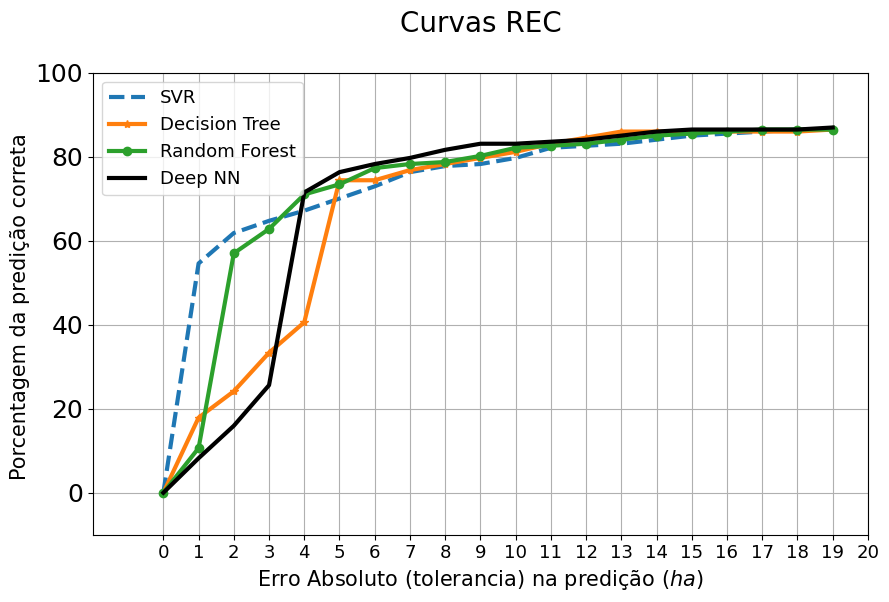

In [10]:
Ranking_ForrestFire = pd.DataFrame()
index_RFF = ['RMSE']
Ranking_ForrestFire  = pd.DataFrame(index=index_RFF)
Ranking_ForrestFire  ['Support Vector Regression'] = RMSE_SVR
Ranking_ForrestFire  ['Decision Tree'] = RMSE_DT
Ranking_ForrestFire  ['Random Forest'] = RMSE_RF
Ranking_ForrestFire  ['Deep Network'] = RMSE_LDNN
#
plt.figure(figsize=(10,6))
plt.title("Curvas REC\n",fontsize=20)
plt.xlabel("Erro Absoluto (tolerancia) na predição ($ha$)",fontsize=15)
plt.ylabel("Porcentagem da predição correta ",fontsize=15)
plt.xticks([i for i in range(0,tol_max+1,1)],fontsize=13)
plt.ylim(-10,100)
plt.xlim(-2,tol_max)
plt.yticks([i*20 for i in range(6)],fontsize=18)
plt.grid(True)
plt.plot(range(tol_max),rec_SVR,'--',lw=3)
plt.plot(range(tol_max),rec_DT,'*-',lw=3)
plt.plot(range(tol_max),rec_RF,'o-',lw=3)
plt.plot(range(tol_max),rec_NN,'k-',lw=3)
plt.legend(['SVR','Decision Tree','Random Forest','Deep NN'],fontsize=13)
Ranking_ForrestFire 